# Recommender System / Matrix Factorisation - Project 2024 Matis Braun SCIA

The project is to do a movie pairing recommender system. We have to develop a recommender system that pairs two movies based on complementary genres, themes or viewer preferences, similar to the concept used on Data Night Movies.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Dropout, MultiHeadAttention, LayerNormalization, Add, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim
import math

2024-07-07 20:43:57.449779: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 20:43:57.449950: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 20:43:57.456225: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


For the project, we will use 2 differents datasets :
- MovieLens, which will be the base of our data. We will use the MovieLens 1M Dataset, and take the movies, the ratings and the users files.
- IMDB, which will complete the MovieLens dataset, by taking the title_basics and the name_basics files. We will see this deeper later. 

In [2]:
movies_path = '/kaggle/input/moviedb/ml-1m/movies.dat'
ratings_path = '/kaggle/input/moviedb/ml-1m/ratings.dat'
users_path = '/kaggle/input/moviedb/ml-1m/users.dat'
title_basics_path = '/kaggle/input/moviedb/ml-1m/title.basics.tsv'
name_basics_path = '/kaggle/input/moviedb/ml-1m/name.basics.tsv'

In the function load_movielens, we create 3 datasets "movies", "ratings" and "users" from MovieLens.

- For "ratings", there will be 4 columns : "userId" which is the id of the user, "moviesId" the movie id he has on his viewed movies, "rating" the score he gived to the movie (to 0 to 5)
- For "users" there will be 4 columns : "userId" which is the id of the user, "gender" the gender of the user, "age" the age of the user and "occupation" the sort of job the user has (like doctor (6), programmer (12), unemployed (19))
- For "movies", we will do first somes changes. On MovieLens dataset, movies have a title like that : ToyStory(1995). But we don't want the date after the title, because for exemple on IMDB dataset, movie title is just ToyStory. So for MovieLens, we will separate the date and the title, and we will create a new column "year". Also, there movies named "Pretender, The" but on IMDB named "The Pretender", so we will change the titles of all title like that. So there will be 4 columns : "movieId" which is the id of the movie, "title" the title of the movie without date, "genres" the genres of the movie and "year" the release year of the movie

In [3]:
def load_movielens(movies_path, ratings_path, users_path):
    movies = pd.read_csv(movies_path, sep='::', engine='python', 
                         names=['movieId', 'title', 'genres'], encoding='latin1')
    
    movies['year'] = movies['title'].str.extract(r'\((\d{4})\)', expand=False)
    movies['title'] = movies['title'].str.replace(r'\(\d{4}\)', '', regex=True).str.strip()
    
    def transform_title(title):
        match = re.search(r'(.+),\s(The|An|A)$', title)
        if match:
            title = f"{match.group(2)} {match.group(1)}"
        return title
    
    movies['title'] = movies['title'].apply(transform_title)
    print(movies)
    
    ratings = pd.read_csv(ratings_path, sep='::', engine='python', 
                          names=['userId', 'movieId', 'rating', 'timestamp'], encoding='latin1')
    ratings = ratings.drop(columns=['timestamp'])
    print(ratings)
    
    users = pd.read_csv(users_path, sep='::', engine='python', 
                        names=['userId', 'gender', 'age', 'occupation', 'zipCode'], encoding='latin1')
    users = users.drop(columns=['zipCode'])
    print(users)
    return movies, ratings, users

In [93]:
movies, ratings, users = load_movielens(movies_path, ratings_path, users_path)

      movieId                        title                        genres  year
0           1                    Toy Story   Animation|Children's|Comedy  1995
1           2                      Jumanji  Adventure|Children's|Fantasy  1995
2           3             Grumpier Old Men                Comedy|Romance  1995
3           4            Waiting to Exhale                  Comedy|Drama  1995
4           5  Father of the Bride Part II                        Comedy  1995
...       ...                          ...                           ...   ...
3878     3948             Meet the Parents                        Comedy  2000
3879     3949          Requiem for a Dream                         Drama  2000
3880     3950                    Tigerland                         Drama  2000
3881     3951             Two Family House                         Drama  2000
3882     3952                The Contender                Drama|Thriller  2000

[3883 rows x 4 columns]
         userId  movieId  r

As we can see below, we have 3883 differents movies on our database, 6040 differents users and 1 000 209 differents ratings 

In [5]:
print(len(movies))
print(len(ratings))
print(len(users))

3883
1000209
6040


In the function load_imdb, we create 2 datasets "title_basics" and "name_basics" from IMDB.
- For title_basics, there will be 5 columns : "tconst" which is the id of the movie, "titleType" the type of the video (here movie), "primaryTitle" the title of the movie, "startYear" the release year of the movie and "genres" the genres of the movie. On title basics, we deleted all the rows where the video was not movie (like tvEpisode, videoGame,...)
- For name_basics, there will be 3 columns : "nconst" which is the id of the public figure in movie, "primaryName" the name of the public figure and "knownForTitles" the movie id where he directed or played or ...

In [6]:
def load_imdb(title_basics_path, name_basics_path):
    title_basics = pd.read_csv(title_basics_path, sep='\t', 
                               usecols=['tconst', 'titleType', 'primaryTitle', 'startYear', 'genres'],
                               dtype={'tconst': str, 'titleType': str, 'primaryTitle': str, 'startYear': str, 'genres': str})
    title_basics['startYear'] = pd.to_numeric(title_basics['startYear'], errors='coerce')
    
    title_basics = title_basics[title_basics['titleType'] != 'tvEpisode']
    title_basics = title_basics[title_basics['titleType'] != 'video']
    title_basics = title_basics[title_basics['titleType'] != 'tvMiniSeries']
    title_basics = title_basics[title_basics['titleType'] != 'tvSpecial']
    title_basics = title_basics[title_basics['titleType'] != 'videoGame']
    
    title_basics = title_basics[title_basics['titleType'] == 'movie']
    print(title_basics)
    
    name_basics = pd.read_csv(name_basics_path, sep='\t',
                              usecols=['nconst', 'primaryName', 'knownForTitles'],
                              dtype={'nconst': str, 'primaryName': str, 'knownForTitles': str})
    
    print(name_basics)
    return title_basics, name_basics

In [7]:
title_basics, name_basics = load_imdb(title_basics_path, name_basics_path)

             tconst titleType  \
8         tt0000009     movie   
144       tt0000147     movie   
498       tt0000502     movie   
570       tt0000574     movie   
587       tt0000591     movie   
...             ...       ...   
10855986  tt9916622     movie   
10856013  tt9916680     movie   
10856025  tt9916706     movie   
10856035  tt9916730     movie   
10856045  tt9916754     movie   

                                               primaryTitle  startYear  \
8                                                Miss Jerry     1894.0   
144                           The Corbett-Fitzsimmons Fight     1897.0   
498                                                Bohemios     1905.0   
570                             The Story of the Kelly Gang     1906.0   
587                                        The Prodigal Son     1907.0   
...                                                     ...        ...   
10855986        Rodolpho Teóphilo - O Legado de um Pioneiro     2015.0   
10856013  D

Below, we can see that 683 874 differents movies and 13 575 526 public figure who worked on movies (directors, actors, editor, makeup artist,...)

In [8]:
print(len(title_basics))
print(len(name_basics))

683874
13575526


In [9]:
def merge_datasets(movies, title_basics):    
    movies['year'] = pd.to_numeric(movies['year'], errors='coerce')
    title_basics['startYear'] = pd.to_numeric(title_basics['startYear'], errors='coerce')
    
    merged_df = pd.merge(movies, title_basics, how='inner', left_on=['title', 'year'], right_on=['primaryTitle', 'startYear'])
    merged_df.drop(columns=['year'], inplace=True)
    
    return merged_df

In [10]:
merged_data = merge_datasets(movies, title_basics)

In [11]:
merged_data

,movieId,title,genres_x,tconst,titleType,primaryTitle,startYear,genres_y
0,1,Toy Story,Animation|Children's|Comedy,tt0114709,movie,Toy Story,1995.0,"Adventure,Animation,Comedy"
1,2,Jumanji,Adventure|Children's|Fantasy,tt0113497,movie,Jumanji,1995.0,"Adventure,Comedy,Family"
2,3,Grumpier Old Men,Comedy|Romance,tt0113228,movie,Grumpier Old Men,1995.0,"Comedy,Romance"
3,4,Waiting to Exhale,Comedy|Drama,tt0114885,movie,Waiting to Exhale,1995.0,"Comedy,Drama,Romance"
4,5,Father of the Bride Part II,Comedy,tt0113041,movie,Father of the Bride Part II,1995.0,"Comedy,Family,Romance"
...,...,...,...,...,...,...,...,...
3088,3948,Meet the Parents,Comedy,tt0212338,movie,Meet the Parents,2000.0,"Comedy,Romance"
3089,3949,Requiem for a Dream,Drama,tt0180093,movie,Requiem for a Dream,2000.0,Drama
3090,3950,Tigerland,Drama,tt0170691,movie,Tigerland,2000.0,"Drama,War"
3091,3951,Two Family House,Drama,tt0202641,movie,Two Family House,2000.0,"Comedy,Drama,Romance"


After, we will enhance the merged_data. For that, we will add staff names, and combining genre information between MovieLens and IMDB

First, we will create a dictionary of movies which maps to the staffs list. After that, we will add the column staff on merged_data using the dictionnary

In second, we will add missing genres, because we have less information in MovieLens than in IMDB, so we will add missing genres of IMDB.

In [12]:
def enhance_with_directors_and_genres(merged_data, name_basics):
    title_staff = name_basics[name_basics['knownForTitles'].notnull()]
    title_staff_dict = {}
    for _, row in title_staff.iterrows():
        titles = row['knownForTitles'].split(',')
        for title in titles:
            if title in title_staff_dict:
                title_staff_dict[title].append(row['primaryName'])
            else:
                title_staff_dict[title] = [row['primaryName']]
    
    merged_data['staff'] = merged_data['tconst'].apply(lambda x: ', '.join(title_staff_dict.get(x, [])))
    
    def merge_genres(genres_ml, genres_imdb):
        if pd.isna(genres_ml):
            return genres_imdb
        genres_ml_set = set(genres_ml.split('|'))
        genres_imdb_set = set(genres_imdb.split(','))
        merged_genres = genres_ml_set.union(genres_imdb_set)
        return '|'.join(merged_genres)
    
    merged_data['genres'] = merged_data.apply(lambda row: merge_genres(row['genres_x'], row['genres_y']), axis=1)
    
    enhanced_data = merged_data[['movieId', 'primaryTitle', 'genres', 'startYear', 'titleType', 'staff', 'tconst']]
    enhanced_data.rename(columns={'primaryTitle': 'title', 'startYear': 'year'}, inplace=True)
    
    return enhanced_data

In [13]:
enhanced_data = enhance_with_directors_and_genres(merged_data, name_basics)

/tmp/ipykernel_1645/4115973951.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enhanced_data.rename(columns={'primaryTitle': 'title', 'startYear': 'year'}, inplace=True)


We saw we have our table with movieId, title, genres (all from MovieLens and IMDB), year, titleType, staff (with all the staff implied on the movie) and tconst

In [14]:
enhanced_data2 = enhanced_data

In [94]:
enhanced_data = enhanced_data2

In [95]:
enhanced_data

,movieId,title,genres,year,titleType,staff,tconst,title_encoded,genres_encoded,staff_encoded
0,1,Toy Story,Adventure|Children's|Comedy|Animation,1995.0,movie,"Tim Allen, John Ratzenberger, Jim Varney, John...",tt0114709,2864,81,2859
1,2,Jumanji,Fantasy|Family|Children's|Comedy|Adventure,1995.0,movie,"Bonnie Hunt, Bebe Neuwirth, Adam Hann-Byrd, Ro...",tt0113497,1222,331,346
2,3,Grumpier Old Men,Romance|Comedy,1995.0,movie,"James Andelin, Richard C. Berman, Les Brown, D...",tt0113228,980,504,1245
3,4,Waiting to Exhale,Romance|Drama|Comedy,1995.0,movie,"Whitney Houston, Kenneth 'Babyface' Edmonds, L...",tt0114885,2952,530,3025
4,5,Father of the Bride Part II,Family|Romance|Comedy,1995.0,movie,"Rodrigo Botero, William Akey, Sam Anderson, Da...",tt0113041,800,303,2523
...,...,...,...,...,...,...,...,...,...,...
3088,3948,Meet the Parents,Romance|Comedy,2000.0,movie,"Blythe Danner, Teri Polo, Tom Houghton, Jon Ab...",tt0212338,1434,504,326
3089,3949,Requiem for a Dream,Drama,2000.0,movie,"Jennifer Connelly, Ellen Burstyn, Jared Leto, ...",tt0180093,1833,232,1356
3090,3950,Tigerland,War|Drama,2000.0,movie,"Karolyn Arnold, Arian Ash, Rhynell Brumfield, ...",tt0170691,2829,649,1639
3091,3951,Two Family House,Romance|Drama|Comedy,2000.0,movie,"Jeffrey L. Baker, Sally Bonython, Adam Carr, R...",tt0202641,2902,530,1350


Now, we will create our user-item interaction matrix for collaborative filtering. On rows are all users and in columns are all movies. If a user rated a movie, there will has a note on the table, otherwise we put a NaN

In [17]:
def create_user_item_matrix(ratings):
    user_item_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
    return user_item_matrix

user_item_matrix = create_user_item_matrix(ratings)
print(user_item_matrix)

movieId  1     2     3     4     5     6     7     8     9     10    ...  \
userId                                                               ...   
1         5.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5         NaN   NaN   NaN   NaN   NaN   2.0   NaN   NaN   NaN   NaN  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
6036      NaN   NaN   NaN   2.0   NaN   3.0   NaN   NaN   NaN   NaN  ...   
6037      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
6038      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
6039      NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
6040      3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

movieId  39

Now, let's look the rating distribution :

We can see the rating is centered between 3 and 4

Ratings Distribution:
 rating
1     56174
2    107557
3    261197
4    348971
5    226310
Name: count, dtype: int64


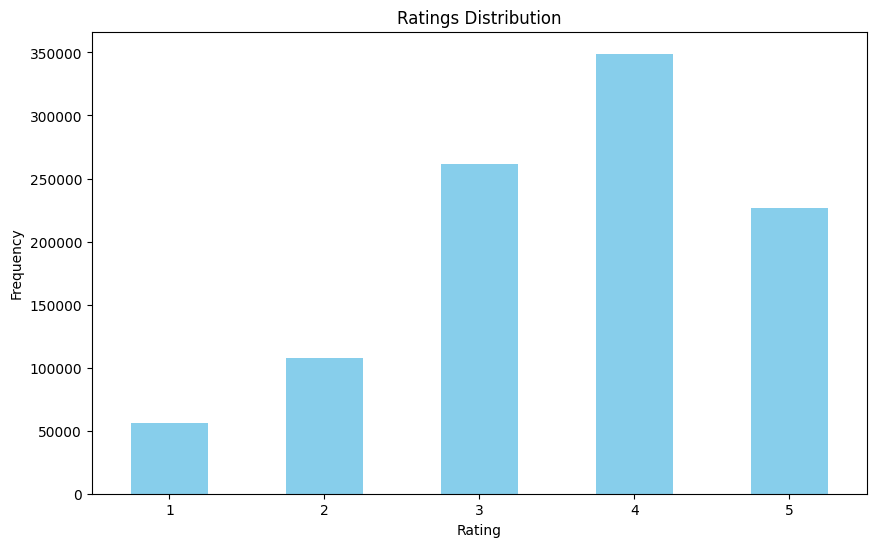

In [18]:
ratings_distribution = ratings['rating'].value_counts().sort_index()
print("Ratings Distribution:\n", ratings_distribution)
plt.figure(figsize=(10, 6))
ratings_distribution.plot(kind='bar', color='skyblue')
plt.title('Ratings Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

Now, let's look the number of ratings per movie :

We can see 1/4 of the movies have less than 10 ratings

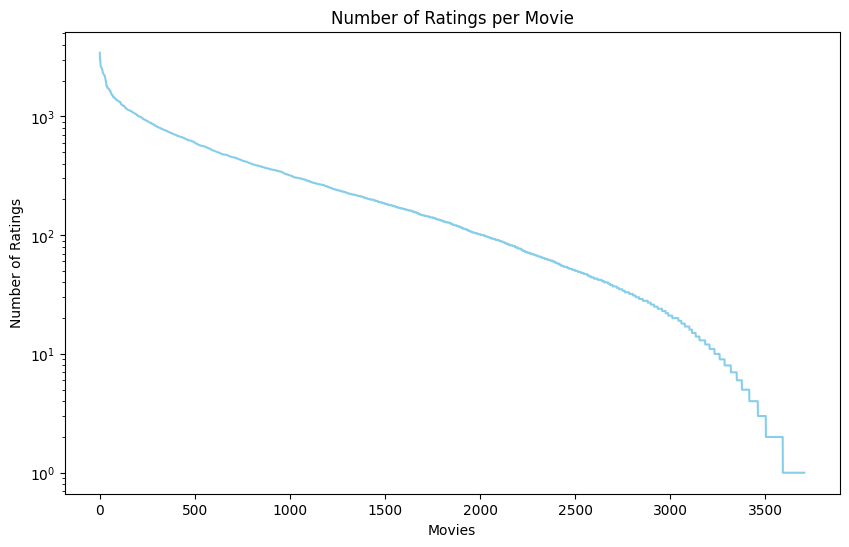

In [19]:
num_ratings_per_movie = ratings.groupby('movieId').size().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
plt.plot(num_ratings_per_movie.values, color='skyblue')
plt.title('Number of Ratings per Movie')
plt.xlabel('Movies')
plt.ylabel('Number of Ratings')
plt.yscale('log')
plt.show()

Now, let's look the number of ratings per user : 

We can see that 1/2 of users have more than 100 rated movies

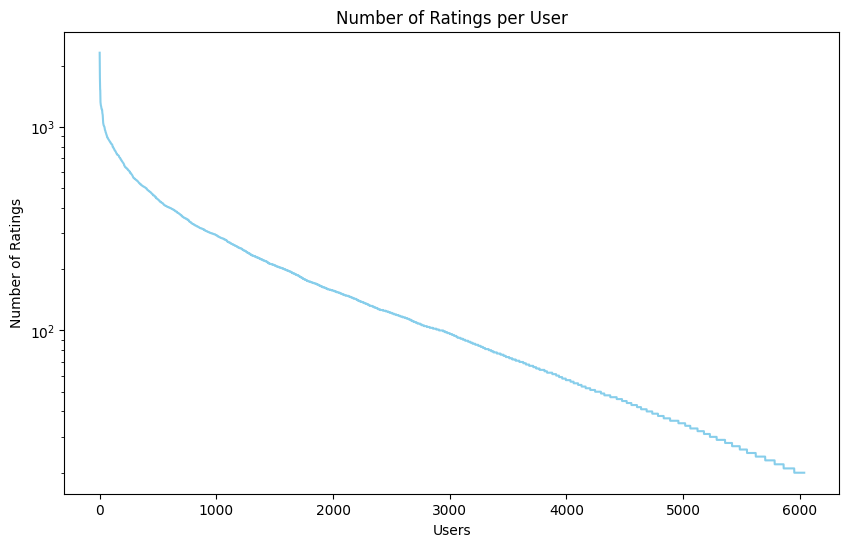

In [20]:
num_ratings_per_user = ratings.groupby('userId').size().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
plt.plot(num_ratings_per_user.values, color='skyblue')
plt.title('Number of Ratings per User')
plt.xlabel('Users')
plt.ylabel('Number of Ratings')
plt.yscale('log')
plt.show()

We want now to implement a recommender system to predict the rating of a movie by a couple of users. To do that, we will use ALS Matrix Factorisation. As we saw on lesson, this method is popular for collaborative filtering, and can handle large dataset. It's a good method used by companies such as Amazon,... so i wanted to use it. The pros are that he is efficient for large dataset, can handle missing data and generalize well. The cons are that he struggle with the cold start problem and has bias to popular.

In [21]:
spark = SparkSession.builder.appName("MovieRecommender").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/07 21:00:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


We create a spark Dataset to use it

In [22]:
ratings_spark = spark.createDataFrame(ratings)

I choose to split training and test to 80%, it's basically what i always do

In [23]:
(training, test) = ratings_spark.randomSplit([0.8, 0.2], seed=42)

I create the ALS Model

In [24]:
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", 
          nonnegative=True, implicitPrefs=False, coldStartStrategy="drop")
model2 = als.fit(training)

24/07/07 21:01:17 WARN TaskSetManager: Stage 0 contains a task of very large size (2400 KiB). The maximum recommended task size is 1000 KiB.
24/07/07 21:01:21 WARN TaskSetManager: Stage 1 contains a task of very large size (2400 KiB). The maximum recommended task size is 1000 KiB.
24/07/07 21:01:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


I wanted to do a HyperParameter Tuning but it don't work (i think i have to divide the dataset)

In [25]:
#param_grid = ParamGridBuilder() \
 #   .addGrid(als.rank, [10, 20, 30]) \
  #  .addGrid(als.maxIter, [10, 20]) \
   # .addGrid(als.regParam, [0.01, 0.1, 0.2]) \
    #.build()
#evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
#crossval = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)
#cv_model = crossval.fit(training)
#best_model = cv_model.bestModel

In [26]:
predictions = model2.transform(test)

Let see our prediction

In [27]:
example_predictions = predictions.select('userId', 'movieId', 'rating', 'prediction').filter((col('userId') == 2) | (col('userId') == 4))
example_predictions_list = example_predictions.collect()

for row in example_predictions_list:
    print(f"For user {row['userId']} and movie {row['movieId']}")
    print(f"Real rating is {row['rating']} predicted rating is {row['prediction']:.2f}.\n")

24/07/07 21:01:43 WARN TaskSetManager: Stage 54 contains a task of very large size (2400 KiB). The maximum recommended task size is 1000 KiB.


For user 2 and movie 1537
Real rating is 4 predicted rating is 3.82.

For user 4 and movie 1210
Real rating is 3 predicted rating is 3.82.

For user 2 and movie 1247
Real rating is 5 predicted rating is 3.83.

For user 2 and movie 1968
Real rating is 2 predicted rating is 3.72.

For user 2 and movie 3256
Real rating is 2 predicted rating is 3.80.

For user 2 and movie 3068
Real rating is 4 predicted rating is 3.59.

For user 2 and movie 1957
Real rating is 5 predicted rating is 3.70.

For user 2 and movie 648
Real rating is 4 predicted rating is 3.37.

For user 2 and movie 1690
Real rating is 3 predicted rating is 2.78.

For user 2 and movie 2728
Real rating is 3 predicted rating is 3.74.

For user 2 and movie 459
Real rating is 3 predicted rating is 2.82.

For user 2 and movie 1610
Real rating is 5 predicted rating is 4.02.

For user 2 and movie 1687
Real rating is 3 predicted rating is 3.02.

For user 2 and movie 110
Real rating is 5 predicted rating is 4.23.

For user 2 and movie 34

Let's see when we round the prediction

In [28]:
def custom_round(rating):
    if rating - int(rating) >= 0.5:
        return int(rating) + 1
    else:
        return int(rating)

round_udf = udf(custom_round, IntegerType())
predictions_with_rounded = predictions.withColumn('rounded_prediction', round_udf(col('prediction')))
example_predictions2 = predictions_with_rounded.select('userId', 'movieId', 'rating', 'rounded_prediction').filter((col('userId') == 2) | (col('userId') == 4))
example_predictions_list2 = example_predictions2.collect()

for row in example_predictions_list2:
    print(f"For user {row['userId']} and movie {row['movieId']}")
    print(f"Real rating is {row['rating']} predicted rating is {row['rounded_prediction']}.\n")

24/07/07 21:01:47 WARN TaskSetManager: Stage 135 contains a task of very large size (2400 KiB). The maximum recommended task size is 1000 KiB.


For user 2 and movie 1537
Real rating is 4 predicted rating is 4.

For user 4 and movie 1210
Real rating is 3 predicted rating is 4.

For user 2 and movie 1247
Real rating is 5 predicted rating is 4.

For user 2 and movie 1968
Real rating is 2 predicted rating is 4.

For user 2 and movie 3256
Real rating is 2 predicted rating is 4.

For user 2 and movie 3068
Real rating is 4 predicted rating is 4.

For user 2 and movie 1957
Real rating is 5 predicted rating is 4.

For user 2 and movie 648
Real rating is 4 predicted rating is 3.

For user 2 and movie 1690
Real rating is 3 predicted rating is 3.

For user 2 and movie 2728
Real rating is 3 predicted rating is 4.

For user 2 and movie 459
Real rating is 3 predicted rating is 3.

For user 2 and movie 1610
Real rating is 5 predicted rating is 4.

For user 2 and movie 1687
Real rating is 3 predicted rating is 3.

For user 2 and movie 110
Real rating is 5 predicted rating is 4.

For user 2 and movie 3418
Real rating is 4 predicted rating is 3.

Here our evaluator. I choosed to use RMSE and MAE :
- For MAE (Mean Absolute Error), we have a value of 0.70, which mean that when we predict a rating to 3, in average the model predict note is between +0.70 or -0.70.
- But i also choose MSE (Mean Squared Error) because using MSE penalizes larges errors (because of the square) so i'ts more strict than MAE, that why it's a different value (and a bigger)

In [29]:
evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

24/07/07 21:01:52 WARN TaskSetManager: Stage 216 contains a task of very large size (2400 KiB). The maximum recommended task size is 1000 KiB.
24/07/07 21:01:55 WARN TaskSetManager: Stage 271 contains a task of very large size (2400 KiB). The maximum recommended task size is 1000 KiB.


RMSE: 0.8734955260841885
MAE: 0.7003659319146557


Here, i wrote 2 functions
- Get_predicted_rating which predict a rating for a movie for a specific user
- Get_couple_predicted_rating which predict a rating for a movie for 2 persons and do the average of the rating

In [30]:
def get_predicted_rating(user_id, movie_id, model):
    user_movie_pair = spark.createDataFrame([(user_id, movie_id)], ["userId", "movieId"])
    prediction = model2.transform(user_movie_pair).collect()[0][2]
    return prediction

def get_couple_predicted_rating(user1_id, user2_id, movie_id, model):
    rating_user1 = get_predicted_rating(user1_id, movie_id, model)
    rating_user2 = get_predicted_rating(user2_id, movie_id, model)
    couple_rating = (rating_user1 + rating_user2) / 2
    return couple_rating

def get_couple_predicted_rating2(user1_id, user2_id, movie_id, model):
    user_movie_pair = spark.createDataFrame([(user1_id, movie_id)], ["userId", "movieId"])
    user_movie_pair2 = spark.createDataFrame([(user2_id, movie_id)], ["userId", "movieId"])
    print(user_movie_pair)
    
get_couple_predicted_rating2(1, 2, 52, model2)

DataFrame[userId: bigint, movieId: bigint]


In [31]:
user1_id = 1
print(users.loc[1])
user2_id = 2
movie_id = 52

predicted_rating_user1 = get_predicted_rating(user1_id, movie_id, model2)
predicted_rating_user2 = get_predicted_rating(user2_id, movie_id, model2)
predicted_rating_couple = get_couple_predicted_rating(user1_id, user2_id, movie_id, model2)

print(f"Predicted rating for user {user1_id} and movie {movie_id}: {predicted_rating_user1}")
print(f"Predicted rating for user {user2_id} and movie {movie_id}: {predicted_rating_user2}")
print(f"Predicted rating for the couple (user {user1_id} and user {user2_id}) and movie {movie_id}: {predicted_rating_couple}")

userId         2
gender         M
age           56
occupation    16
Name: 1, dtype: object


Predicted rating for user 1 and movie 52: 3.4543097019195557
Predicted rating for user 2 and movie 52: 3.2565741539001465
Predicted rating for the couple (user 1 and user 2) and movie 52: 3.355441927909851


So we have a recommender system algorithm which predict the rating of a movie by a couple of users. And is prediction of the rating varied between -0.7 and +0.7 points

Now, we want to develop an algorithm to suggest one movie that might be liked by the couple of users

I choosed to do a Neural Network Encoder. I tried to do first the TransformerEncoding because for me its a new method with better result and prediction,... but i didn't manage to do it so i choose the 2nd choice the Neural Network Encoding

First we have to encode the features : using LabelEncoding, we transform all into numerical values for our neural network.
Aftter, we add the features transformed to the rating dataset
I choose to split training and test to 80%, it's basically what i always do

In [112]:
title = LabelEncoder()
enhanced_data.loc[:, 'title_encoded'] = title.fit_transform(enhanced_data['title'])
genres = LabelEncoder()
enhanced_data.loc[:, 'genres_encoded'] = genres.fit_transform(enhanced_data['genres'])
staff = LabelEncoder()
enhanced_data.loc[:, 'staff_encoded'] = staff.fit_transform(enhanced_data['staff'])

ratings = ratings.merge(enhanced_data[['movieId', 'title_encoded', 'genres_encoded', 'staff_encoded']],
                        on='movieId', how='left', suffixes=('', '_enhanced'))

ratings = ratings.drop_duplicates(subset=['userId', 'movieId'])

user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')
user_movie_matrix.fillna(0, inplace=True)

train_matrix, test_matrix = train_test_split(user_movie_matrix, test_size=0.2, random_state=42)

num_users = ratings['userId'].max()
num_movies = ratings['movieId'].max()
num_titles = enhanced_data['title_encoded'].max()
num_genres = enhanced_data['genres_encoded'].max()
num_staff = enhanced_data['staff_encoded'].max()

In [113]:
print(ratings2)

         userId  movieId  rating  title_encoded  genres_encoded  staff_encoded
0             1     1193       5         1636.0           232.0         1234.0
1             1      661       3         1195.0           106.0          620.0
2             1      914       3         1534.0           542.0          236.0
3             1     3408       4          749.0           124.0         1606.0
4             1     2355       5           22.0            81.0          702.0
...         ...      ...     ...            ...             ...            ...
1005292    6040     1091       1         2966.0           190.0          142.0
1005293    6040     1094       5         2325.0           593.0         1318.0
1005294    6040      562       5         2968.0           239.0         1144.0
1005295    6040     1096       4         2039.0           527.0         2025.0
1005296    6040     1097       4          720.0           324.0          905.0

[1000209 rows x 6 columns]


In [110]:
num_users = ratings2['userId'].max()
num_movies = ratings2['movieId'].max()
num_titles = ratings2['title_encoded'].max()
num_genres = ratings2['genres_encoded'].max()
num_staff = ratings2['staff_encoded'].max()

print(num_users)
print(num_movies)dd
print(num_titles)
print(num_genres)
print(num_staff)

6040
3952
3040.0
667.0
3086.0


So here the Neural Network : 
- We create a embedding layers for all informations we want to use : userId, movieId, title, genres and staff (so 1D vector)
- We concatenate all embeddings
- We applies multiple Dense layers using Relu 

So i did a basic model

After, we compile our model and we will use the MSE Loss for the loss function and we will use the Adam optimizer for our Neural Network

In [114]:
class MovieFeaturesNN(nn.Module):
    def __init__(self, num_users, num_movies, num_titles, num_genres, num_staff, embedding_size=50):
        super(MovieFeaturesNN, self).__init__()
        self.user_embedding = nn.Embedding(num_users + 1, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies + 1, embedding_size)
        self.title_embedding = nn.Embedding(num_titles + 1, embedding_size)
        self.genres_embedding = nn.Embedding(num_genres + 1, embedding_size)
        self.staff_embedding = nn.Embedding(num_staff + 1, embedding_size)
        
        combined_embedding_size = embedding_size * 5
        self.fc1 = nn.Linear(combined_embedding_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, user_ids, movie_ids, title_ids, genre_ids, staff_ids):
        user_embeds = self.user_embedding(user_ids)
        movie_embeds = self.movie_embedding(movie_ids)
        title_embeds = self.title_embedding(title_ids)
        genres_embeds = self.genres_embedding(genre_ids)
        staff_embeds = self.staff_embedding(staff_ids)
        
        x = torch.cat([user_embeds, movie_embeds, title_embeds, genres_embeds, staff_embeds], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MovieFeaturesNN(num_users, num_movies, num_titles, num_genres, num_staff)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


TO train our model, we will use batch processing to train better our neural network. 

# WARNING

I don't know why, but my model doesn't work anymore. I had tested it multiple times and it worked, but when i did a Restart and clear all output, and did a Run All, it doesn't worked anymore. When i evaluated my model with thr RMSE below, i get a value of 0.90, and my loss was around 0.012 after 5 epochs

In [115]:
def train_model(model, ratings, num_epochs=5, batch_size=64):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for i in range(0, len(ratings), batch_size):
            batch = ratings.iloc[i:i+batch_size]
            user_ids = torch.tensor(batch['userId'].values, dtype=torch.long)
            movie_ids = torch.tensor(batch['movieId'].values, dtype=torch.long)
            title_ids = torch.tensor(batch['title_encoded'].values, dtype=torch.long)
            genre_ids = torch.tensor(batch['genres_encoded'].values, dtype=torch.long)
            staff_ids = torch.tensor(batch['staff_encoded'].values, dtype=torch.long)
            ratings_tensor = torch.tensor(batch['rating'].values, dtype=torch.float32)

            # Debugging prints to check ranges
            print(f"Batch {i//batch_size + 1} - Max user_id: {user_ids.max()}, Max movie_id: {movie_ids.max()}, Max title_id: {title_ids.max()}, Max genre_id: {genre_ids.max()}, Max staff_id: {staff_ids.max()}")

            # Check for out-of-range indices
            if (user_ids.max() > 6040 or movie_ids.max() > 3952 or 
                title_ids.max() > 3040 or genre_ids.max() > 668 or 
                staff_ids.max() > 3086):
                print(f"Out of range index found in batch {i//batch_size + 1}")
                print(f"user_ids: {user_ids}")
                print(f"movie_ids: {movie_ids}")
                print(f"title_ids: {title_ids}")
                print(f"genre_ids: {genre_ids}")
                print(f"staff_ids: {staff_ids}")
                raise ValueError("Index out of range detected in the batch")

            optimizer.zero_grad()
            outputs = model(user_ids, movie_ids, title_ids, genre_ids, staff_ids).squeeze()
            loss = criterion(outputs, ratings_tensor)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(ratings)}")

# Assuming ratings DataFrame is already defined
train_model(model, ratings)


Batch 1 - Max user_id: 2, Max movie_id: 3468, Max title_id: 2865, Max genre_id: 630, Max staff_id: 3062


IndexError: index out of range in self

In [ ]:
def recommend_for_couple_nn(model, ratings, enhanced_data, user1, user2):
    user_ids = torch.tensor([user1, user2], dtype=torch.long)
    movie_ids = torch.tensor(enhanced_data['movieId'].values, dtype=torch.long)
    title_ids = torch.tensor(enhanced_data['title_encoded'].values, dtype=torch.long)
    genre_ids = torch.tensor(enhanced_data['genres_encoded'].values, dtype=torch.long)
    staff_ids = torch.tensor(enhanced_data['staff_encoded'].values, dtype=torch.long)

    user1_ratings = model(user_ids[0].repeat(len(movie_ids)), movie_ids, title_ids, genre_ids, staff_ids).squeeze().detach().numpy()
    user2_ratings = model(user_ids[1].repeat(len(movie_ids)), movie_ids, title_ids, genre_ids, staff_ids).squeeze().detach().numpy()

    couple_scores = (user1_ratings + user2_ratings) / 2

    rated_movies_user1 = ratings[ratings['userId'] == user1]['movieId'].values
    rated_movies_user2 = ratings[ratings['userId'] == user2]['movieId'].values
    rated_movies = set(rated_movies_user1).union(set(rated_movies_user2))

    for movie_id in rated_movies:
        couple_scores[enhanced_data[enhanced_data['movieId'] == movie_id].index] = -1

    top_indices = np.argsort(couple_scores)[-top_n:][::-1]
    recommended_movies = enhanced_data.iloc[top_indices]
    recommended_scores = couple_scores[top_indices]
    return recommended_movies, recommended_scores

user1, user2 = 1, 2
recommended_movie_id, score = recommend_for_couple_nn(model, ratings, enhanced_data, user1, user2)
print(f"Recommended Movie ID: {recommended_movie_id}, Score: {score}")

recommended_movie_details = enhanced_data[enhanced_data['movieId'] == recommended_movie_id]
print(recommended_movie_details)


In [ ]:
def evaluate_model(model, test_data):
    model.eval()
    with torch.no_grad():
        user_ids = torch.tensor(test_data['userId'].values, dtype=torch.long)
        movie_ids = torch.tensor(test_data['movieId'].values, dtype=torch.long)
        title_ids = torch.tensor(test_data['title_encoded'].values, dtype=torch.long)
        genre_ids = torch.tensor(test_data['genres_encoded'].values, dtype=torch.long)
        staff_ids = torch.tensor(test_data['staff_encoded'].values, dtype=torch.long)
        actual_ratings = torch.tensor(test_data['rating'].values, dtype=torch.float32)

        predicted_ratings = model(user_ids, movie_ids, title_ids, genre_ids, staff_ids).squeeze()
        
        mse = mean_squared_error(actual_ratings, predicted_ratings)
        rmse = math.sqrt(mse)
        return rmse

train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)
rmse = evaluate_model(model, test_data)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")